In [1]:
import numpy as np
import heapq
from operator import itemgetter
import numpy.linalg as LA
import xml.etree.ElementTree as et, pandas as pd, re
from bs4 import BeautifulSoup
import gensim
from markdown import markdown
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
xtree = et.parse('Posts.xml')

xroot = xtree.getroot()

dfCols = ["Closed Date", "Favorite Count", "Comment Count", "Answer Count", "Tags", "Title",
          "Last Activity Date", "Owner User ID", "Body", "View Count", "Score", "Creation Date", "Post Type ID", 
          "ID", "Parent ID", "Last Edit Date", "Last Editor User ID", "Accepted Answer ID"]
dfRows = []

In [3]:
for node in xroot:
    closedDate = node.attrib.get("ClosedDate")
    favCount = node.attrib.get("FavoriteCount")
    commentCount = node.attrib.get("CommentCount")
    ansCount = node.attrib.get("AnswerCount")
    tags = node.attrib.get("Tags")
    title = node.attrib.get("Title")
    lastActDate = node.attrib.get("LastActivityDate")
    ownerUserID = node.attrib.get("OwnerUserId")
    body = node.attrib.get("Body")
    viewCount = node.attrib.get("ViewCount") 
    score = node.attrib.get("Score") 
    creationDate = node.attrib.get("CreationDate") 
    postTypeID = node.attrib.get("PostTypeId") 
    ID = node.attrib.get("Id") 
    parentID = node.attrib.get("ParentId") 
    lastEditDate = node.attrib.get("LastEditDate") 
    lastEditorUserID = node.attrib.get("LastEditorUserId") 
    acceptedAnswerID = node.attrib.get("AcceptedAnswerID")
    
    dfRows.append({"Closed Date": closedDate, "Favorite Count": favCount, "Comment Count": commentCount,
                     "Answer Count": ansCount, "Tags": tags, "Title": title, "Last Activity Date": lastActDate,
                     "Owner User ID": ownerUserID, "Body": body, "View Count": viewCount, "Score": score, 
                    "Creation Date": creationDate, "Post Type ID": postTypeID, "ID": ID, "Parent ID": parentID,
                    "Last Edit Date": lastEditDate, "Last Editor User ID": lastEditorUserID, "Accepted Answer ID": acceptedAnswerID})

In [4]:
out = pd.DataFrame(dfRows, columns=dfCols)

out = out.fillna(0)

out['Creation Date'] = pd.to_datetime(out['Creation Date'])
out['Creation Date'] = out['Creation Date'].dt.strftime('%Y/%m/%d')
out['Comment Count'] = out['Comment Count'].astype(int)
out['Owner User ID'] = out['Owner User ID'].astype(int)
out['Post Type ID'] = out['Post Type ID'].astype(int)
out['Score'] = out['Score'].astype(int)
out['Favorite Count'] = out['Favorite Count'].astype(int)
out['Answer Count'] = out['Answer Count'].astype(int)
out['View Count'] = out['View Count'].astype(int)

answers = out[(out['Post Type ID'] == 1)]

answers = answers[['ID','Creation Date','Tags','Title','Body']]

#words kolonu title ile bodynin birleşmiş hali, 
answers['Words'] = answers[['Title', 'Body', 'Tags']].apply(lambda x: ' '.join(x), axis=1)

answers['Words'].apply(lambda x: ''.join(BeautifulSoup(markdown(x)).findAll(text=True)))
answers.head

<bound method NDFrame.head of           ID Creation Date                                               Tags  \
0          1    2016/08/02  <neural-networks><backpropagation><terminology...   
1          2    2016/08/02  <neural-networks><machine-learning><statistica...   
3          4    2016/08/02                    <deep-network><search><neurons>   
4          5    2016/08/02                               <python><mindstorms>   
5          6    2016/08/02       <philosophy><definitions><intelligent-agent>   
6          7    2016/08/02                                <intelligent-agent>   
9         10    2016/08/02           <deep-network><terminology><fuzzy-logic>   
12        13    2016/08/02               <neural-networks><image-recognition>   
14        15    2016/08/02  <turing-test><strong-ai><intelligent-agent><we...   
15        16    2016/08/02  <deep-learning><definitions><overfitting><regu...   
16        17    2016/08/02  <philosophy><definitions><agi><superintelligen...  

In [5]:
size = len(answers.ID.to_list())

In [6]:
id_set = answers.ID.to_list() #Documents

In [7]:
def read_corpus(fname, tokens_only=False):
    for i, line in enumerate(fname):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [int(id_set[i])])

In [8]:
trainData =answers['Words'].tolist()#[:4068]
testData =answers['Words'].tolist()[4068:]
tags = dict(zip(answers.ID.astype(int), answers.Tags))

In [9]:
train_corpus = list(read_corpus(trainData))
test_corpus = list(read_corpus(testData, tokens_only=True))

In [10]:
idTextDict = dict(zip(answers.ID, answers.Words))

In [11]:
#model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=1, epochs=200)
model = gensim.models.doc2vec.Doc2Vec(min_count=1,window=5,vector_size=300,workers=5,alpha=0.025,min_alpha=0.00025,dm=1, epochs = 50)
#model = gensim.models.doc2vec.Doc2Vec(min_count=2,window=15,vector_size=300,workers=5,alpha=0.025,min_alpha=0.00025,dm=0, epochs=100)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [12]:
doc_id = id_set.index("14119")
print(doc_id)
inferred_vector = model.infer_vector(test_corpus[doc_id-4068])
sims = model.docvecs.most_similar([inferred_vector], topn=100)
print(id_set[id_set.index("14119")])

4356
14119


In [13]:
print(id_set.index("13425"))
id_set[id_set.index("13425")]

4068


'13425'

In [14]:
for (item,val) in sims:
    print(item, val)

14119 0.9364782571792603
15932 0.37294119596481323
1289 0.3690992593765259
13398 0.3602584898471832
15713 0.3595762550830841
5274 0.3579294979572296
7926 0.34869682788848877
1420 0.34739869832992554
1897 0.340761661529541
3024 0.34038621187210083
16741 0.3371763229370117
6 0.33657312393188477
2066 0.3354340195655823
11208 0.33535096049308777
13866 0.33177649974823
3775 0.3302019238471985
8854 0.32728591561317444
5258 0.32612329721450806
6161 0.3257138431072235
12593 0.3225095868110657
7 0.32203012704849243
9924 0.31965571641921997
2642 0.3181639313697815
2048 0.31813257932662964
6584 0.31744369864463806
6421 0.3167300820350647
13261 0.31494900584220886
11500 0.31336528062820435
7573 0.3126540184020996
15449 0.31164583563804626
1376 0.3091354966163635
9439 0.3075100779533386
2111 0.3053240180015564
5018 0.3042410612106323
4533 0.30351635813713074
1501 0.30272164940834045
1658 0.30258041620254517
5156 0.3021986484527588
2430 0.30189239978790283
6125 0.3012242317199707
1824 0.300364196300

In [15]:
cosineResultDict = {}
for i in range(0, len(test_corpus)):
    inferred_vector = model.infer_vector(test_corpus[i])
    sims = model.docvecs.most_similar([inferred_vector], topn=100)
    cosineResultDict[int(id_set[4068+i])] = sims 

In [16]:
cosineResultDict[13425]

[(13425, 0.9127515554428101),
 (3397, 0.40745994448661804),
 (7986, 0.3706238567829132),
 (3310, 0.37041330337524414),
 (4933, 0.3688887357711792),
 (10621, 0.36849159002304077),
 (5502, 0.36677032709121704),
 (13297, 0.3596516251564026),
 (2214, 0.35376232862472534),
 (7273, 0.35216760635375977),
 (13630, 0.3504357933998108),
 (10534, 0.34897518157958984),
 (15497, 0.3487095534801483),
 (8689, 0.3457232117652893),
 (11261, 0.34546637535095215),
 (10892, 0.3449063003063202),
 (11534, 0.3444787263870239),
 (9496, 0.34443795680999756),
 (2048, 0.34148913621902466),
 (5070, 0.3402043581008911),
 (13434, 0.3396095633506775),
 (12544, 0.3395601809024811),
 (4612, 0.3363586366176605),
 (15668, 0.335613489151001),
 (16646, 0.3341987431049347),
 (15837, 0.3341578543186188),
 (12805, 0.33365774154663086),
 (2999, 0.3334748446941376),
 (8844, 0.33340907096862793),
 (15752, 0.33042222261428833),
 (6313, 0.32906731963157654),
 (10508, 0.32866090536117554),
 (2634, 0.327533096075058),
 (13934, 0.32

In [17]:
relatedId = {}
with open("relatedFrom13425_test.txt") as f:
    for line in f:
        (key, val) = line.split(",")
        relatedId[int(key)] = [int(i) for i in val.strip().split()]
relatedId

{13425: [8828, 54, 8594, 7446, 7838, 3176, 12991, 11523],
 13426: [18081, 17948, 15999, 13343, 10839, 6318],
 13429: [17530, 15910, 13968, 12268, 11878, 10719, 9829, 7580, 4984],
 13432: [17775, 13907, 16120, 2524, 7273, 3453, 4421],
 13434: [18232, 1742, 17002, 16384, 8637, 11152, 4576],
 13435: [17629, 2381, 12433, 12086, 3298, 6115, 4139, 3702],
 13436: [9504, 11119, 7518, 7417],
 13437: [16322, 16131, 12255, 10586, 9590, 5332],
 13443: [15562, 12897, 12021, 10145, 8580, 5836, 4131, 5208, 2793],
 13444: [10053, 12397, 16443, 13531, 11513, 11593, 9937],
 13448: [10556, 2127, 1946, 1488, 12116, 4764, 3457, 1318],
 13449: [5904, 17094, 16171, 3469, 10734, 5855],
 13450: [16447, 16564, 13156],
 13451: [17160, 12734, 2911, 12954, 5928],
 13454: [17004, 13975, 13573, 13549, 5769, 12649, 12366, 8929, 7949],
 13457: [9197, 11679, 15918, 13147, 12053, 8128, 7707, 5454],
 13460: [15408, 2598, 6975, 6741, 5114, 2672],
 13464: [17108, 4085, 7685, 8212, 7832, 7408],
 13466: [17619, 12469, 12408,

In [18]:
crossCheckDict = {}
bothRelatedAndSim = {}
for key in cosineResultDict.keys():
    counter = 0
    if key in relatedId.keys():
        for rel in relatedId[key]:
            for (simId,sim) in cosineResultDict[key]:
                if rel == simId:
                    if key in bothRelatedAndSim.keys():
                        bothRelatedAndSim[key].append((simId,sim))
                    else:
                        bothRelatedAndSim[key] = [(simId,sim)]

                    counter += 1
    crossCheckDict[key] = counter


In [19]:
crossCheckDict

{13425: 1,
 13426: 0,
 13429: 4,
 13432: 0,
 13434: 2,
 13435: 0,
 13436: 0,
 13437: 0,
 13443: 1,
 13444: 1,
 13448: 3,
 13449: 0,
 13450: 0,
 13451: 1,
 13454: 7,
 13457: 3,
 13460: 0,
 13464: 2,
 13466: 2,
 13470: 2,
 13472: 1,
 13473: 1,
 13475: 0,
 13476: 2,
 13478: 3,
 13479: 1,
 13482: 0,
 13487: 0,
 13489: 1,
 13494: 0,
 13495: 3,
 13498: 0,
 13499: 1,
 13502: 4,
 13503: 0,
 13504: 1,
 13507: 2,
 13508: 1,
 13510: 0,
 13515: 3,
 13516: 0,
 13518: 0,
 13522: 3,
 13523: 2,
 13524: 3,
 13526: 1,
 13527: 1,
 13529: 3,
 13531: 2,
 13538: 1,
 13540: 2,
 13544: 2,
 13545: 1,
 13549: 3,
 13550: 2,
 13551: 1,
 13552: 4,
 13554: 2,
 13555: 2,
 13556: 0,
 13557: 1,
 13560: 3,
 13562: 1,
 13566: 1,
 13567: 2,
 13568: 1,
 13570: 1,
 13572: 1,
 13573: 5,
 13575: 1,
 13576: 0,
 13577: 2,
 13580: 1,
 13593: 1,
 13595: 2,
 13596: 1,
 13600: 2,
 13603: 0,
 13604: 3,
 13605: 1,
 13607: 0,
 13612: 1,
 13613: 1,
 13615: 1,
 13617: 3,
 13619: 1,
 13620: 1,
 13622: 0,
 13627: 2,
 13630: 0,
 13631: 3,

Sıfır related matchleyen caselere örnek:
14173 - relatedla sorunun alakası yok denecek kadar az - bizim bulduklarımız similarity degerine göre daha mantıklı
14204 - hiç related yok - bizim bulduklarımız some what similar
13849 - soru ve relatedları arasında 1-2 kelime matchliyor, anlam acısından bag yok - bizim bulduklarımızın context olarak benzerliği daha fazla

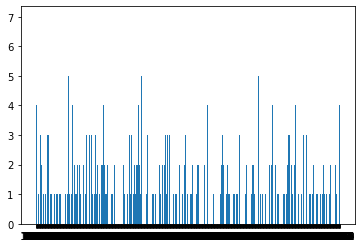

In [20]:
plt.bar(range(len(crossCheckDict)), list(crossCheckDict.values()), align='center')
plt.xticks(range(len(crossCheckDict)), list(crossCheckDict.keys()))
plt.show()

In [21]:
listOfVals = crossCheckDict.values()

In [22]:
len(listOfVals)

1018

On average how many similar related questions that stack exchange and our doc2vec model suggests

In [23]:
sum(listOfVals)/len(listOfVals)

1.1316306483300589

In [24]:
sum(listOfVals)

1152

In [25]:
for key in bothRelatedAndSim.keys():
    print("https://ai.stackexchange.com/questions/" + str(key))
    print([i for i,j in bothRelatedAndSim[key]])

https://ai.stackexchange.com/questions/13425
[7446]
https://ai.stackexchange.com/questions/13429
[15910, 9829, 7580, 4984]
https://ai.stackexchange.com/questions/13434
[1742, 8637]
https://ai.stackexchange.com/questions/13443
[5836]
https://ai.stackexchange.com/questions/13444
[13531]
https://ai.stackexchange.com/questions/13448
[2127, 1488, 3457]
https://ai.stackexchange.com/questions/13451
[12954]
https://ai.stackexchange.com/questions/13454
[13573, 13549, 5769, 12649, 12366, 8929, 7949]
https://ai.stackexchange.com/questions/13457
[9197, 12053, 5454]
https://ai.stackexchange.com/questions/13464
[7685, 7832]
https://ai.stackexchange.com/questions/13466
[12469, 12408]
https://ai.stackexchange.com/questions/13470
[16850, 5769]
https://ai.stackexchange.com/questions/13472
[7550]
https://ai.stackexchange.com/questions/13473
[3518]
https://ai.stackexchange.com/questions/13476
[16076, 13028]
https://ai.stackexchange.com/questions/13478
[9197, 10797, 7707]
https://ai.stackexchange.com/quest

In [26]:
f = open("DOC2VEC_RELATEDDICT.txt", "a")
for key in bothRelatedAndSim:  
    f.write(str(key)+"\t"+str([i for i,j in bothRelatedAndSim[key]])+"\n")
f.close()

In [27]:
for key in crossCheckDict.keys():
    if crossCheckDict[key] == 0:
        print("https://ai.stackexchange.com/questions/" + str(key))


https://ai.stackexchange.com/questions/13426
https://ai.stackexchange.com/questions/13432
https://ai.stackexchange.com/questions/13435
https://ai.stackexchange.com/questions/13436
https://ai.stackexchange.com/questions/13437
https://ai.stackexchange.com/questions/13449
https://ai.stackexchange.com/questions/13450
https://ai.stackexchange.com/questions/13460
https://ai.stackexchange.com/questions/13475
https://ai.stackexchange.com/questions/13482
https://ai.stackexchange.com/questions/13487
https://ai.stackexchange.com/questions/13494
https://ai.stackexchange.com/questions/13498
https://ai.stackexchange.com/questions/13503
https://ai.stackexchange.com/questions/13510
https://ai.stackexchange.com/questions/13516
https://ai.stackexchange.com/questions/13518
https://ai.stackexchange.com/questions/13556
https://ai.stackexchange.com/questions/13576
https://ai.stackexchange.com/questions/13603
https://ai.stackexchange.com/questions/13607
https://ai.stackexchange.com/questions/13622
https://ai

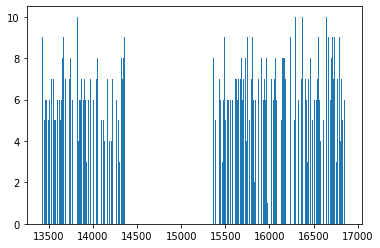

In [28]:
x = relatedId.keys()
bins = []

for key in x:
    bins.append(len(relatedId[key]))

width = bins[1] - bins[0]
plt.bar(x, bins, align='center', width=width)
plt.show()


In [29]:
tags[1]

'<neural-networks><backpropagation><terminology><definitions>'

In [30]:
for key in tags.keys():
    s = tags[key].replace("<", "", len(tags[key]))
    s = s.replace(">", " ", len(tags[key]))
    tags[key] = s.strip().split(" ")


In [31]:
key = 13544
print(key, relatedId[key])
print(tags[key])
for item in relatedId[key]:
    if item in tags.keys():
        print(item, tags[item])

13544 [4376, 8518, 2817, 12671, 8962, 6139]
['neural-networks', 'recurrent-neural-networks', 'optimization', 'logic', 'function-approximation']
4376 ['neural-networks']
8518 ['neural-networks', 'machine-learning', 'backpropagation']
2817 ['optimization', 'heuristics']
12671 ['neural-networks', 'function-approximation']
8962 ['machine-learning', 'backpropagation', 'terminology', 'optimization']
6139 ['neural-networks', 'ai-design', 'optimization']


import requests
APIKEY = "unCQQDAhgl)qZ4GZRXVVGQ((";

query = "https://api.stackexchange.com/2.2/questions/" + str(54)+"?order=desc&sort=activity&site=ai&key="+APIKEY;
response = requests.get(query)


print(response.json()["items"][0]["tags"])

Api ile websitesi eşleşiyor ama post.xml dosyasındakiler ile eşleşmiyor

import time

betterTags = {}

for id in id_set:
    if id not in betterTags.keys():
        query = "https://api.stackexchange.com/2.2/questions/" + str(id)+"?order=desc&sort=activity&site=ai&key="+APIKEY;
        response = requests.get(query)
        print(response.status_code)
        betterTags[id] = response.json()["items"][0]["tags"]
        print(id, betterTags[id])
        time.sleep(1)

betterTags

In [32]:
tagVsQuestion = {}
for key in relatedId.keys():
    #print(key, relatedId[key])
    #print(tags[key])
    true = 0
    false = 0
    for item in relatedId[key]:
        if item in tags.keys():
            #print(item, tags[item])
            #print(np.in1d(tags[key],tags[item]).any())
            if np.in1d(tags[key],tags[item]).any():
                true += 1
            else:
                false += 0
            if true+false == 0:
                tagVsQuestion[key] = 0
            else:
                print(true,false)
                tagVsQuestion[key] = float(true /(true+false))
        else:
            tagVsQuestion[key] = 0


1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
1 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0


3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
1 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
1 0
2 0


4 0
5 0
6 0
7 0
8 0
9 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
1 0
2 0
3 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
1 0
2 0
3 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
4 0
5 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
1 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
1 0
2 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
1 0
2 0
3 0
4 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
1 0
2 0
3 0
4 0
5 0
6 0

In [41]:
tagVsQuestion[13425]

1.0

In [34]:
print([x for x in tagVsQuestion.keys() if tagVsQuestion[x] == 0])

[15415, 15451, 15515, 16017, 16490]


sadec 5 tane eşleşmiyor o datalarda elimizde mevcut değil normalde çalışıyorlar

In [35]:
model.save("doc2vecmodel")

In [36]:
model2 = gensim.models.doc2vec.Doc2Vec.load("doc2vecmodel")

In [37]:
inferred_vector = model.infer_vector(["asda"])
sims = model.docvecs.most_similar([inferred_vector], topn=100)

In [38]:
sims

[(13942, 0.2265402376651764),
 (10761, 0.19402962923049927),
 (9386, 0.1903691589832306),
 (1244, 0.1889793574810028),
 (5737, 0.18698400259017944),
 (4046, 0.18598362803459167),
 (6946, 0.1777496635913849),
 (14613, 0.17702728509902954),
 (138, 0.17516937851905823),
 (4699, 0.17506931722164154),
 (1017, 0.1745343953371048),
 (13602, 0.17431683838367462),
 (5969, 0.17372161149978638),
 (10274, 0.17357204854488373),
 (8964, 0.17099598050117493),
 (15597, 0.17087526619434357),
 (13896, 0.17059874534606934),
 (5791, 0.16969749331474304),
 (9145, 0.16944915056228638),
 (6610, 0.1688409000635147),
 (7890, 0.16858908534049988),
 (13102, 0.16838277876377106),
 (5888, 0.16785986721515656),
 (6357, 0.1673867404460907),
 (8233, 0.16521227359771729),
 (1720, 0.1637844294309616),
 (15863, 0.16048428416252136),
 (79, 0.16043967008590698),
 (14381, 0.15973341464996338),
 (6364, 0.15798160433769226),
 (6516, 0.1578918844461441),
 (7800, 0.15740971267223358),
 (6906, 0.15709063410758972),
 (380, 0.156